## Time Series Forecasting: Model Development and Hyperparameter Tuning

### Project Overview

This project focuses on the development and evaluation of various time series forecasting models. The goal is to assess the effectiveness of different approaches—Auto-Regressive (AR), Moving Average (MA), ARIMA (Auto-Regressive Integrated Moving Average), SARIMA (Seasonal ARIMA), ARIMAX (ARIMA with Exogenous Variables), and SARIMAX (Seasonal ARIMAX with Exogenous Variables)—in predicting future values in time series data. Additionally, the project explores the impact of hyperparameter tuning using **Optuna** to optimize model configurations and improve predictive accuracy.

### Objective

The main objectives of this project are:
1. To evaluate the performance of various time series forecasting models (AR, MA, ARIMA, SARIMA, ARIMAX, and SARIMAX).
2. To apply hyperparameter tuning using **Optuna** to improve model accuracy.
3. To compare the models' performance before and after hyperparameter tuning using standard evaluation metrics (MAE, RMSE, MSE, and MAPE).
4. To identify the best-performing model for future predictions and demonstrate the impact of tuning on model performance.

### Dataset and Features

The dataset used for this project consists of time series data with a monthly frequency. Exogenous variables (external factors) are included in the dataset, providing additional information to improve forecasting accuracy. The models were evaluated based on their ability to forecast future values while considering seasonality, trends, and external variables.

### Approach

1. **Model Development**: Fit initial models (AR, MA, ARIMA, SARIMA, ARIMAX, SARIMAX) to the time series data.
2. **Hyperparameter Tuning**: Use **Optuna** to optimize the hyperparameters for each model, enhancing the models' performance.
3. **Evaluation**: Assess the models' performance using standard metrics such as MAE, RMSE, MSE, and MAPE before and after tuning.
4. **Comparison**: Compare the results to identify the most accurate model and analyze the effects of hyperparameter tuning.

This document outlines the methodology, results, and conclusions of the project, along with the final evaluation of the best-performing model.


In [31]:
# Load the dataset
import pandas as pd

# Replace with your file path if running locally
file_path = '/content/FINAL_DATASET.xlsx'
masterdata = pd.read_excel(file_path)

# Display the first few rows to understand the data
print(masterdata.head())


   Quantity  Impressions  Clicks  Imputed_Quantity  Log_quantity  Log_clicks  \
0        14          620     445             14.00      2.708050    6.100319   
1        10          890     433             10.00      2.397895    6.073045   
2        13          851     424             13.00      2.639057    6.052089   
3        22          881     427             22.00      3.135494    6.059123   
4        33          678     451             30.67      3.526361    6.113682   

   Log_impressions YearMonth Monthname  Dayofweek  ...  April  May  June  \
0         6.431331   2021-12  December  Wednesday  ...      0    0     0   
1         6.792344   2021-12  December   Thursday  ...      0    0     0   
2         6.747587   2021-12  December     Friday  ...      0    0     0   
3         6.782192   2021-12  December   Saturday  ...      0    0     0   
4         6.520621   2021-12  December     Sunday  ...      0    0     0   

   July  August  September  October  November  December  Categ

###Check for Stationarity
We use the Augmented Dickey-Fuller (ADF) Test to check if the time series is stationary.

In [33]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    """
    Perform Augmented Dickey-Fuller test to check stationarity of a time series.
    """
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary. Consider differencing.")
    return result[1] < 0.05  # Returns True if stationary

# Check stationarity of the 'imputed_Quantity' column
is_stationary = check_stationarity(masterdata['Imputed_Quantity'])



ADF Statistic: -4.372460988868511
p-value: 0.0003319752426367818
The series is stationary.


###Perform Differencing (If Required)
If the series is non-stationary, perform differencing to remove trends.

In [35]:
import matplotlib.pyplot as plt
# Perform differencing if the series is non-stationary
if not is_stationary:
    masterdata['Differenced_Quantity'] = masterdata['imputed_Quantity'].diff().dropna()
    print("Differencing applied to make the series stationary.")
else:
    masterdata['Differenced_Quantity'] = masterdata['Imputed_Quantity']


###Visualize Trends and Seasonal Patterns
Plot the time series to analyze trends and seasonality.

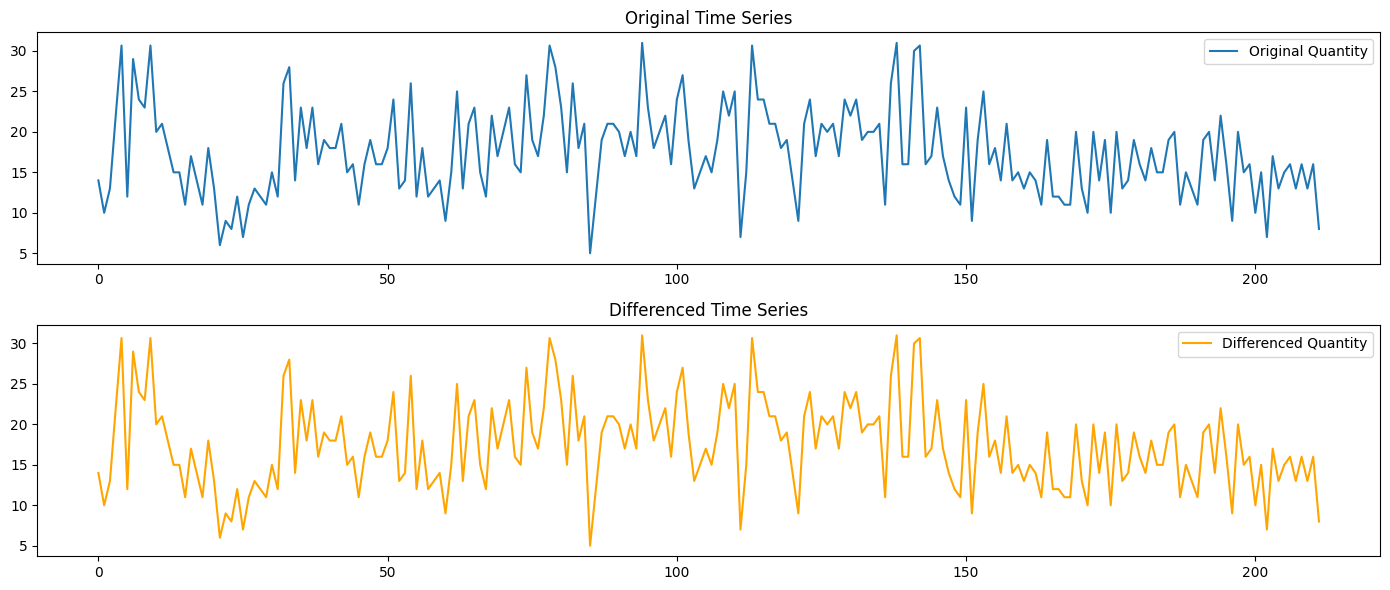

In [39]:
import matplotlib.pyplot as plt

# Plot the original and differenced series
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(masterdata['Imputed_Quantity'], label='Original Quantity')
plt.title('Original Time Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( masterdata['Differenced_Quantity'], label='Differenced Quantity', color='orange')
plt.title('Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.show()


###Train-Test Split
We split the data into training and testing sets for both target and exogenous variables.

In [41]:
# Define train-test split (70%-30%)
train_size = int(0.7 * len(masterdata))

# Define train and test datasets for the target variable
train_target = masterdata['Imputed_Quantity'][:train_size]
test_target = masterdata['Imputed_Quantity'][train_size:]

# Define train and test datasets for exogenous variables (if required later)
exogenous_vars = ['Impressions', 'Clicks', 'Month_numeric', 'Weekofmonth',
                  'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
train_exog = masterdata[exogenous_vars][:train_size]
test_exog = masterdata[exogenous_vars][train_size:]


###Helper Functions
a. Evaluation Metrics:

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mse = mean_squared_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    return mae, rmse, mse, mape


b. Plotting Predictions:



In [43]:
import matplotlib.pyplot as plt

# Function to plot true vs predicted values
def plot_model_predictions(true_values, predicted_values, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.index, true_values, label='True Values')
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='orange')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel("Time")
    plt.ylabel("Sales Quantity")
    plt.show()


### ARIMA (AutoRegressive Integrated Moving Average) Model

In [44]:
from statsmodels.tsa.arima.model import ARIMA

# Fit AR(1) model (ARIMA with order=(1, 0, 0))
ar_model = ARIMA(train_target, order=(1, 0, 0))
ar_model_fit = ar_model.fit()

# Display model summary
print(ar_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:       Imputed_Quantity   No. Observations:                  148
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -462.220
Date:                Tue, 26 Nov 2024   AIC                            930.440
Time:                        17:58:51   BIC                            939.431
Sample:                             0   HQIC                           934.093
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.4317      0.637     28.930      0.000      17.183      19.680
ar.L1          0.2801      0.079      3.554      0.000       0.126       0.435
sigma2        30.1976      3.750      8.053      0.0

5. Generate Predictions

In [45]:
# Forecast the test set length
ar_predictions = ar_model_fit.forecast(steps=len(test_target))

# Convert predictions to a DataFrame for proper indexing
ar_predictions = pd.Series(ar_predictions, index=test_target.index)

# Display first few predictions
print("AR Model Predictions:\n", ar_predictions.head())


AR Model Predictions:
 148    17.190395
149    18.084015
150    18.334315
151    18.404423
152    18.424060
Name: predicted_mean, dtype: float64


6. Evaluate and Visualize AR Model

Evaluation:

In [46]:
# Calculate metrics for the AR model
print("\nEvaluation Metrics for AR Model:")
ar_metrics = calculate_metrics(test_target, ar_predictions)



Evaluation Metrics for AR Model:
Mean Absolute Error (MAE): 4.29
Root Mean Squared Error (RMSE): 5.08
Mean Squared Error (MSE): 25.77
Mean Absolute Percentage Error (MAPE): 35.40%


Visualization:

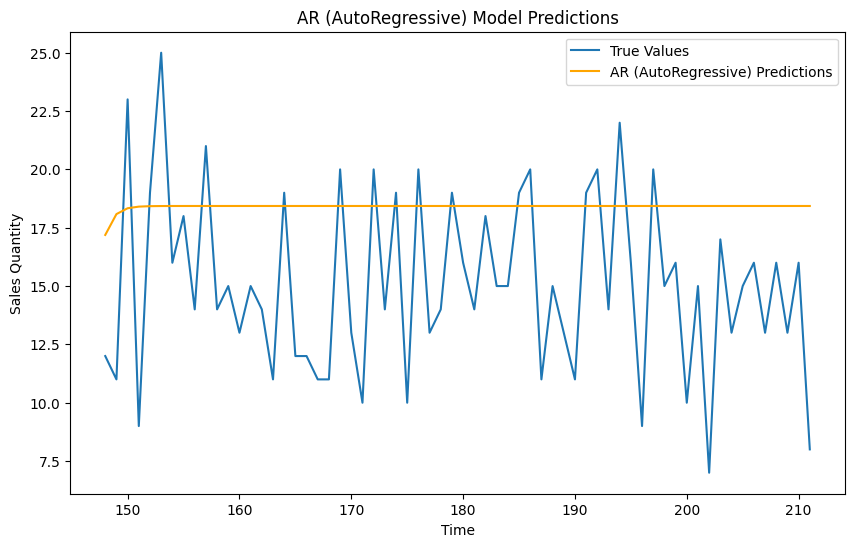

In [47]:
# Plot predictions vs true values
plot_model_predictions(test_target, ar_predictions, "AR (AutoRegressive)")


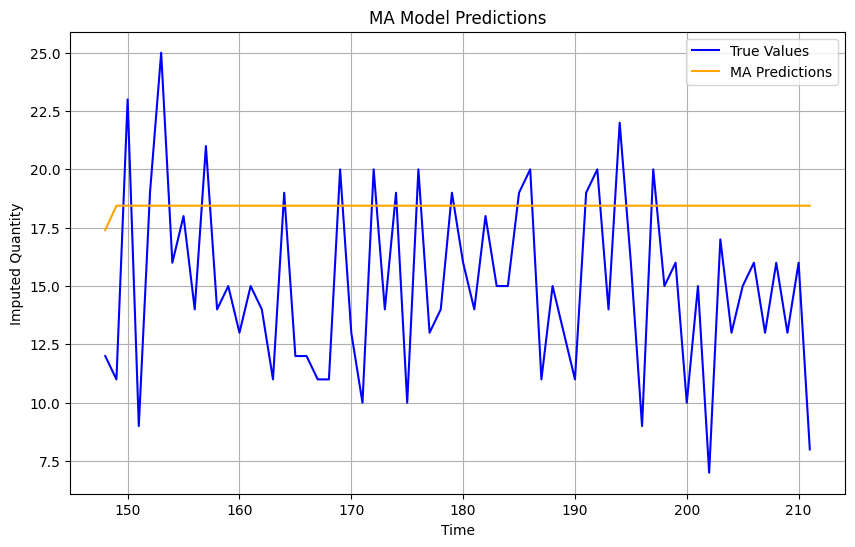

Moving Average (MA) Model Evaluation Metrics:
Mean Absolute Error (MAE): 4.2990
Root Mean Squared Error (RMSE): 5.0942
Mean Squared Error (MSE): 25.9506
Mean Absolute Percentage Error (MAPE): 35.52%


In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset (Ensure correct path and file format)
masterdata = pd.read_excel('/content/FINAL_DATASET.xlsx')

# Train-test split
train_size = int(0.7 * len(masterdata))
train = masterdata['Imputed_Quantity'][:train_size]
test = masterdata['Imputed_Quantity'][train_size:]

# Define Helper Functions

## Function to calculate evaluation metrics
def calculate_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mse = mean_squared_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mae, rmse, mse, mape

## Function to plot model predictions
def plot_model_predictions(true_values, predicted_values, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values.index, true_values, label='True Values', color='blue')
    plt.plot(true_values.index, predicted_values, label=f'{model_name} Predictions', color='orange')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Time')
    plt.ylabel('Imputed Quantity')
    plt.grid(True)
    plt.show()

# Moving Average (MA) Model Implementation
ma_model = ARIMA(train, order=(0, 0, 1))  # ARIMA with only MA component
ma_model_fit = ma_model.fit()
ma_predictions = ma_model_fit.forecast(steps=len(test))

# Plot and Evaluate MA Model
plot_model_predictions(test, ma_predictions, "MA")
ma_metrics = calculate_metrics(test, ma_predictions)

# Display Metrics
print("Moving Average (MA) Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {ma_metrics[0]:.4f}")
print(f"Root Mean Squared Error (RMSE): {ma_metrics[1]:.4f}")
print(f"Mean Squared Error (MSE): {ma_metrics[2]:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {ma_metrics[3]:.2f}%")


# **ARIMA Model Implementation**


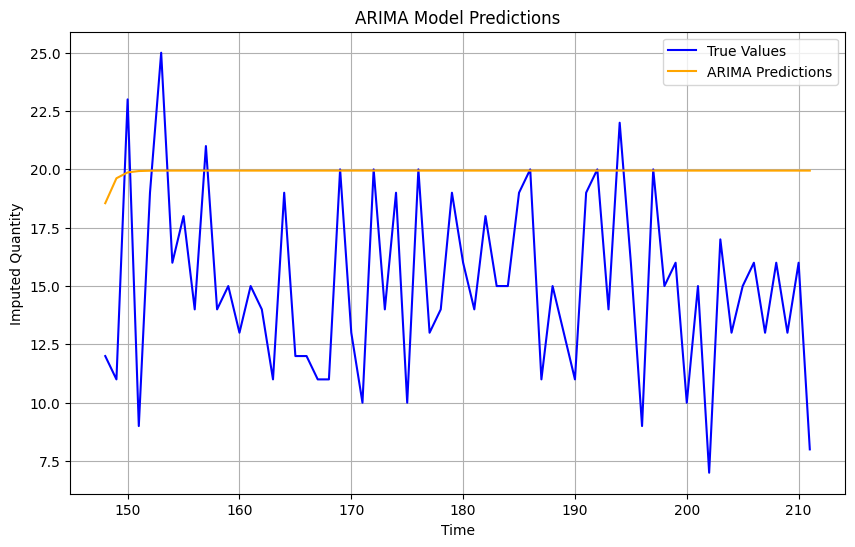

ARIMA Model Evaluation Metrics:
Mean Absolute Error (MAE): 5.2192
Root Mean Squared Error (RMSE): 6.1786
Mean Squared Error (MSE): 38.1746
Mean Absolute Percentage Error (MAPE): 43.35%


In [51]:
## Step 1: Define and Fit the ARIMA Model

# ARIMA with parameters (1, 1, 1)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

## Step 2: Forecast Using the ARIMA Model
arima_predictions = arima_model_fit.forecast(steps=len(test))

## Step 3: Plot ARIMA Model Predictions
plot_model_predictions(test, arima_predictions, "ARIMA")

## Step 4: Evaluate ARIMA Model Performance
arima_metrics = calculate_metrics(test, arima_predictions)

# Display ARIMA Model Evaluation Metrics
print("ARIMA Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {arima_metrics[0]:.4f}")
print(f"Root Mean Squared Error (RMSE): {arima_metrics[1]:.4f}")
print(f"Mean Squared Error (MSE): {arima_metrics[2]:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {arima_metrics[3]:.2f}%")


### Function to Plot Residuals




In [52]:
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title(f'Residual Plot for {model_name}')
    plt.legend()
    plt.show()

### ARIMA Hyperparameter Tuning with Optuna
 Suggests ARIMA parameters (p, d, q) and evaluates performance using RMSE.


In [53]:
def objective_arima(trial):
    # Suggest hyperparameters for ARIMA
    p = trial.suggest_int("p", 1, 5)  # Autoregressive terms
    d = trial.suggest_int("d", 0, 2)  # Differencing terms
    q = trial.suggest_int("q", 1, 5)  # Moving average terms

    # Fit ARIMA model with suggested parameters
    model = ARIMA(train, order=(p, d, q))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test, predictions))


### Optimize ARIMA Parameters Using Optuna
 Runs 50 trials to minimize RMSE and identifies the best (p, d, q) parameters.


In [57]:
# Import necessary libraries
import optuna  # For hyperparameter optimization

study_arima = optuna.create_study(direction='minimize')  # Minimize RMSE
study_arima.optimize(objective_arima, n_trials=50)  # Run for 50 trials

# Extract and display the best parameters
best_arima_params = study_arima.best_params
print("Best ARIMA Parameters:", best_arima_params)


[I 2024-11-26 18:13:34,437] A new study created in memory with name: no-name-6dc2f9c3-a943-4387-825d-7368fbf708b8
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-26 18:13:36,862] Trial 0 finished with value: 8.139354023354972 and parameters: {'p': 3, 'd': 2, 'q': 4}. Best is trial 0 with value: 8.139354023354972.
/usr/local/lib/python

Best ARIMA Parameters: {'p': 1, 'd': 2, 'q': 1}


###ARIMA with Best Tuned Parameters

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Tuned Metrics: (3.104095226225181, 3.876701896920834, 15.02881759758959, 23.08486310834081)


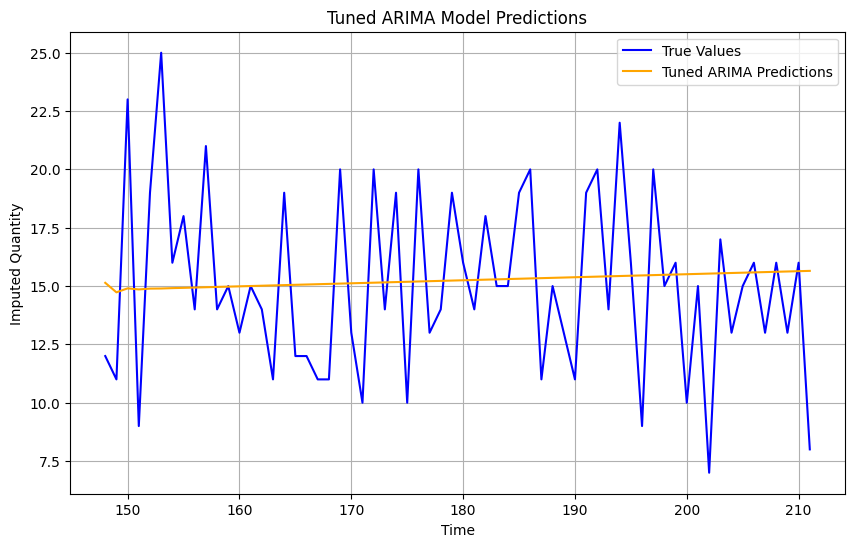

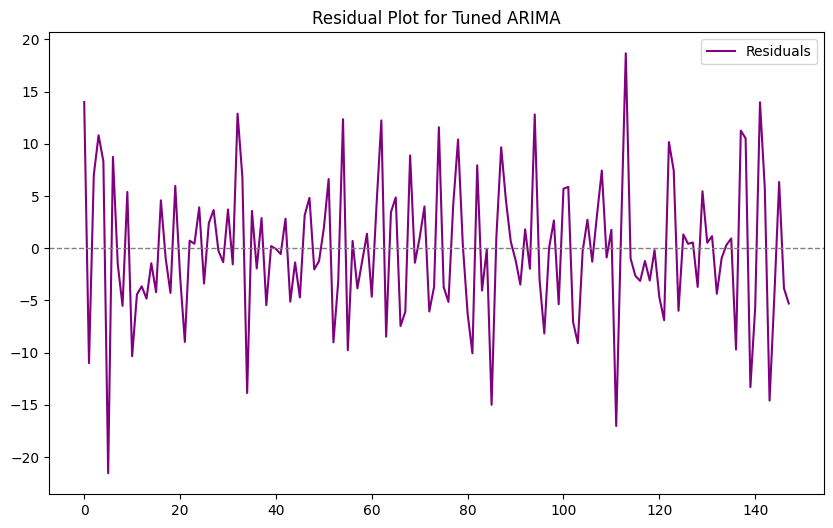

In [58]:
# Fit ARIMA with best parameters
arima_tuned_model = ARIMA(train,
                          order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_tuned_model_fit = arima_tuned_model.fit()

# Predict with ARIMA tuned
arima_tuned_predictions = arima_tuned_model_fit.forecast(len(test))

# Evaluate ARIMA tuned
arima_tuned_metrics = calculate_metrics(test, arima_tuned_predictions)
print("ARIMA Tuned Metrics:", arima_tuned_metrics)

# Plot ARIMA tuned predictions
plot_model_predictions(test, arima_tuned_predictions, "Tuned ARIMA")
plot_residuals(arima_tuned_model_fit, "Tuned ARIMA")


# **SARIMA Model Implementation**

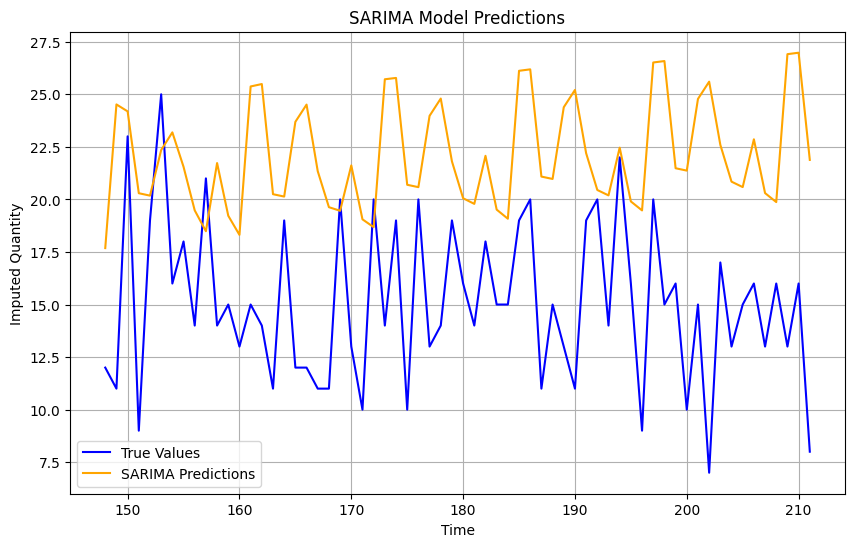

SARIMA Metrics: (7.2201949296471115, 8.309884832870658, 69.05418593557381, 57.90005280657151)


In [60]:
# Import SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA Model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

# Predict with SARIMA
sarima_predictions = sarima_model_fit.forecast(len(test))

# Plot and Evaluate SARIMA Model
plot_model_predictions(test, sarima_predictions, "SARIMA")
sarima_metrics = calculate_metrics(test, sarima_predictions)
print("SARIMA Metrics:", sarima_metrics)


##SARIMA Hyperparameter Tuning:

Objective Function for SARIMA Hyperparameter Tuning



In [61]:
# SARIMA Hyperparameter Tuning
def objective_sarima(trial):
    # Define the range for each hyperparameter
    p = trial.suggest_int("p", 1, 5)  # AR term
    d = trial.suggest_int("d", 0, 2)  # Differencing term
    q = trial.suggest_int("q", 1, 5)  # MA term
    P = trial.suggest_int("P", 0, 2)  # Seasonal AR term
    D = trial.suggest_int("D", 0, 1)  # Seasonal differencing term
    Q = trial.suggest_int("Q", 0, 2)  # Seasonal MA term
    s = 12  # Fixed seasonal period (monthly data)

    # Fit SARIMA model with suggested parameters
    model = SARIMAX(train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s))
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.forecast(len(test))

    # Return RMSE (Root Mean Squared Error) as the objective metric for optimization
    return np.sqrt(mean_squared_error(test, predictions))


Optuna Study for SARIMA Optimization

In [62]:
# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')  # Minimize RMSE
study_sarima.optimize(objective_sarima, n_trials=50)  # Run for 50 trials

# Get the best SARIMA parameters
best_sarima_params = study_sarima.best_params

# Print the best parameters found by Optuna
print("Best SARIMA Parameters:", best_sarima_params)


[I 2024-11-26 18:21:45,231] A new study created in memory with name: no-name-5f37255f-f4eb-4eff-b022-a97571624cfb
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-26 18:21:48,645] Trial 0 finished with value: 8.376249045800414 and parameters: {'p': 4, 'd': 2, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}. Best is trial 0 with value: 8.376249045800414.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

Best SARIMA Parameters: {'p': 5, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 2}


###SARIMA Tuned Model:

In [63]:
# Fit SARIMA with best parameters
sarima_tuned_model = SARIMAX(train,
                             order=(best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q']),
                             seasonal_order=(best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], 12))
sarima_tuned_model_fit = sarima_tuned_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
# Predict with SARIMA tuned
sarima_tuned_predictions = sarima_tuned_model_fit.forecast(len(test))


In [65]:
# Evaluate SARIMA tuned
sarima_tuned_metrics = calculate_metrics(test, sarima_tuned_predictions)
print("SARIMA Tuned Metrics:", sarima_tuned_metrics)


SARIMA Tuned Metrics: (3.613922055827689, 4.131174232600046, 17.066600540098577, 25.805253643385555)


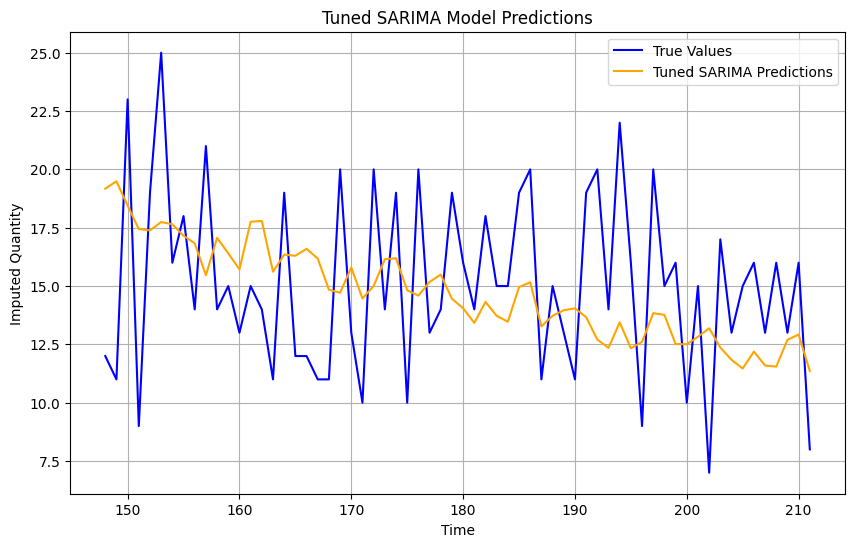

In [66]:
# Plot SARIMA tuned predictions
plot_model_predictions(test, sarima_tuned_predictions, "Tuned SARIMA")


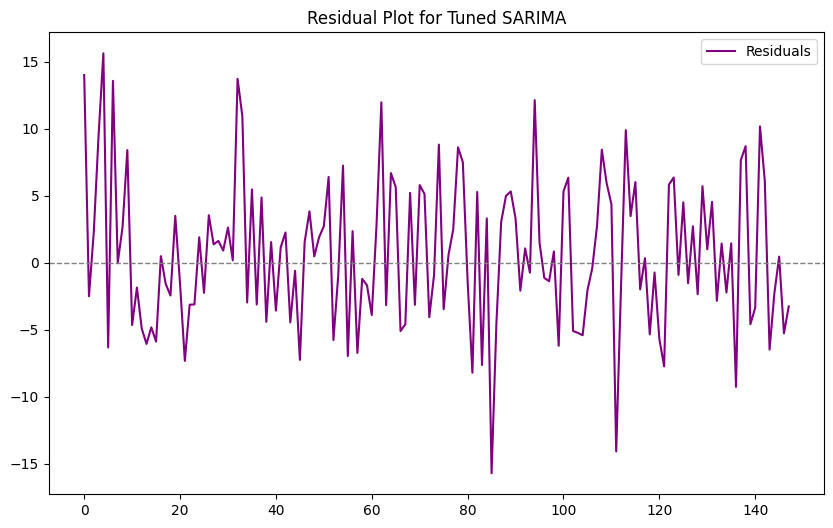

In [67]:
# Plot residuals for SARIMA tuned model
plot_residuals(sarima_tuned_model_fit, "Tuned SARIMA")


# **ARIMAX Model Implementation**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


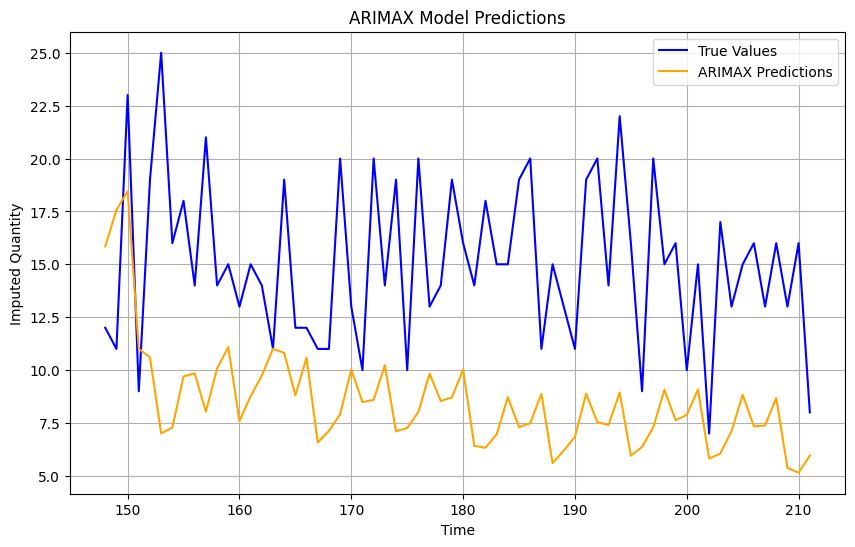

In [69]:
# Fit ARIMAX model with exogenous variables
arimax_model = ARIMA(train, order=(1, 1, 1), exog=train_exog)  # ARIMAX includes exogenous variables
arimax_model_fit = arimax_model.fit()

# Forecast using ARIMAX model
arimax_predictions = arimax_model_fit.forecast(len(test), exog=test_exog)

# Plot ARIMAX model predictions
plot_model_predictions(test, arimax_predictions, "ARIMAX")

# Calculate evaluation metrics for ARIMAX model
arimax_metrics = calculate_metrics(test, arimax_predictions)


###ARIMAX model hyperparameter tuning

In [70]:
# Import necessary libraries for Optuna and ARIMAX
import optuna
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the objective function for ARIMAX hyperparameter tuning
def objective_arimax(trial):
    # Suggest hyperparameters for ARIMAX
    p = trial.suggest_int("p", 1, 5)  # AR term
    d = trial.suggest_int("d", 0, 2)  # Differencing term
    q = trial.suggest_int("q", 1, 5)  # MA term

    # Fit ARIMAX model with trial parameters
    model = ARIMA(train, order=(p, d, q), exog=train_exog)  # ARIMAX includes exogenous variables
    model_fit = model.fit()

    # Forecast using the trained ARIMAX model
    predictions = model_fit.forecast(len(test), exog=test_exog)

    # Return RMSE as the objective metric for Optuna optimization
    return np.sqrt(mean_squared_error(test, predictions))

# Create an Optuna study to minimize RMSE and optimize hyperparameters
study_arimax = optuna.create_study(direction='minimize')
study_arimax.optimize(objective_arimax, n_trials=50)

# Get and print the best ARIMAX hyperparameters
best_arimax_params = study_arimax.best_params
print("Best ARIMAX Parameters:", best_arimax_params)


[I 2024-11-26 18:32:29,547] A new study created in memory with name: no-name-4b4efcaf-7b79-4039-866f-d54bbe726476
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-26 18:32:32,677] Trial 0 finished with value: 6.1092705085321946 and parameters: {'p': 4, 'd': 2, 'q': 5}. Best is trial 0 with value: 6.1092705085321946.
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-26 18:32:34,924] Trial 1 finished with value: 5.794912702183558 and parameters: {'p': 1, 'd': 1, 'q': 4}. Best is trial 1 with value: 5.794912702183558.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary s

Best ARIMAX Parameters: {'p': 4, 'd': 2, 'q': 1}


Fitting the ARIMAX Model with Best Parameters:

In [71]:
arimax_tuned_model = ARIMA(train, order=(best_arimax_params['p'], best_arimax_params['d'], best_arimax_params['q']), exog=train_exog)
arimax_tuned_model_fit = arimax_tuned_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Making Predictions:

In [72]:
arimax_tuned_predictions = arimax_tuned_model_fit.forecast(len(test), exog=test_exog)


Evaluating the Model:

In [73]:
arimax_tuned_metrics = calculate_metrics(test, arimax_tuned_predictions)
print("ARIMAX Tuned Metrics:", arimax_tuned_metrics)


ARIMAX Tuned Metrics: (3.4134825434323566, 4.388749207120505, 19.261119603000864, 22.8127391822796)


Plotting Model Predictions:

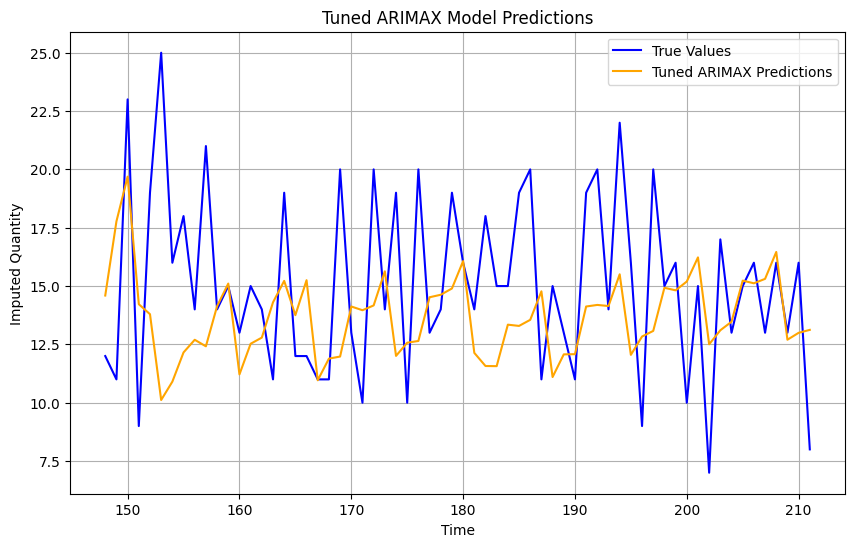

In [74]:
plot_model_predictions(test, arimax_tuned_predictions, "Tuned ARIMAX")


Plotting Residuals:

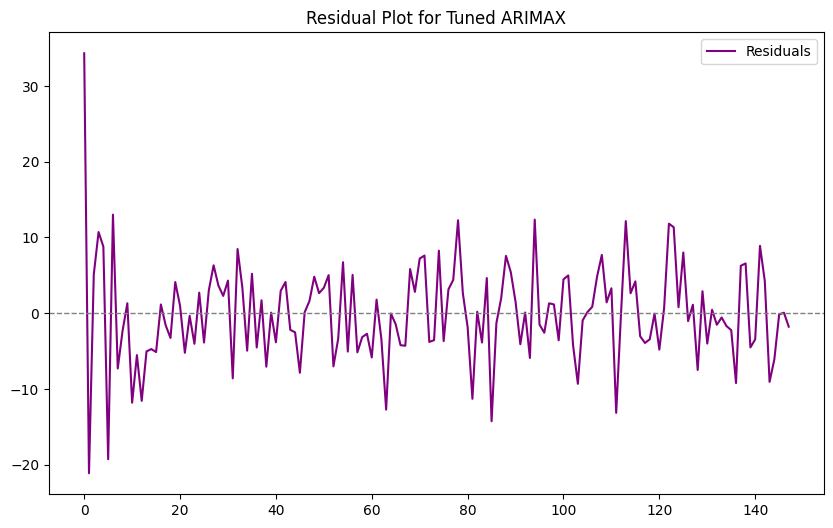

In [75]:
plot_residuals(arimax_tuned_model_fit, "Tuned ARIMAX")


# **SARIMAX Model Implementation**

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX Metrics: (12.792860564702401, 14.108285440638255, 199.04371807452534, 98.01168652711401)


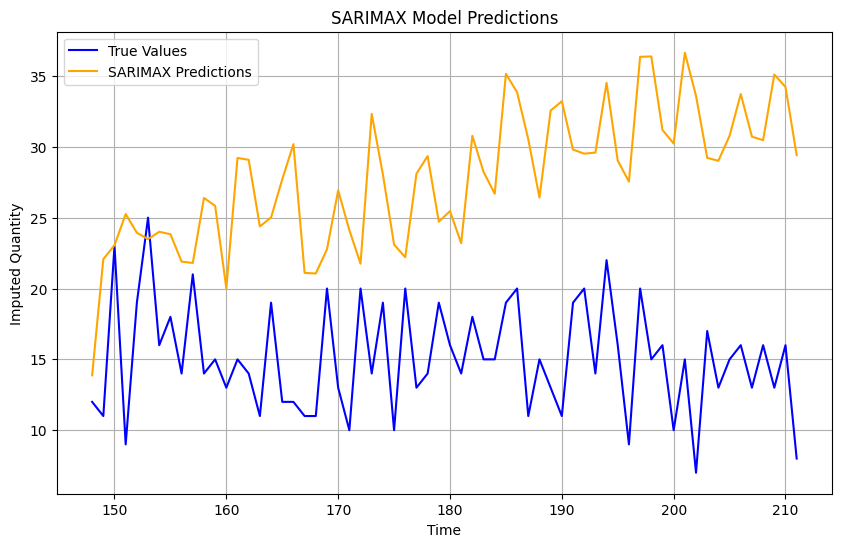

In [76]:
# Fit SARIMAX model with exogenous variables
sarimax_model = SARIMAX(train,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),  # Seasonal order (12 for monthly data)
                        exog=train_exog)  # Exogenous variables during training
sarimax_model_fit = sarimax_model.fit()  # Fit the SARIMAX model

# Predict using SARIMAX model with exogenous variables for the test data
sarimax_predictions = sarimax_model_fit.forecast(len(test), exog=test_exog)  # Forecast for the test set

# Evaluate SARIMAX model using evaluation metrics
sarimax_metrics = calculate_metrics(test, sarimax_predictions)  # Call the function to calculate metrics
print("SARIMAX Metrics:", sarimax_metrics)  # Print out the evaluation metrics

# Plot the SARIMAX model predictions against the actual test values
plot_model_predictions(test, sarimax_predictions, "SARIMAX")  # Visualize the model's performance


###SARIMAX Hyperparameter Tuning

In [77]:
# Define the objective function for SARIMAX hyperparameter tuning
def objective_sarimax(trial):
    # Suggest hyperparameters for SARIMAX model
    p = trial.suggest_int("p", 1, 5)  # AR term
    d = trial.suggest_int("d", 0, 2)  # Differencing order
    q = trial.suggest_int("q", 1, 5)  # MA term
    P = trial.suggest_int("P", 0, 2)  # Seasonal AR term
    D = trial.suggest_int("D", 0, 1)  # Seasonal differencing order
    Q = trial.suggest_int("Q", 0, 2)  # Seasonal MA term
    s = 12  # Fixed seasonal period (monthly data)

    # Fit SARIMAX with trial parameters
    model = SARIMAX(train,
                    order=(p, d, q),  # ARIMA part of SARIMAX
                    seasonal_order=(P, D, Q, s),  # Seasonal part of SARIMAX
                    enforce_stationarity=True,  # Ensure stationarity
                    enforce_invertibility=True,  # Ensure invertibility
                    exog=train_exog)  # Exogenous variables
    model_fit = model.fit()  # Fit the model to the training data

    # Forecast using the fitted SARIMAX model
    predictions = model_fit.forecast(len(test), exog=test_exog)  # Forecast using test exogenous variables

    # Return RMSE as the objective metric for optimization
    return np.sqrt(mean_squared_error(test, predictions))

# Create an Optuna study for SARIMAX with the objective to minimize RMSE
study_sarimax = optuna.create_study(direction='minimize')  # Minimize RMSE
study_sarimax.optimize(objective_sarimax, n_trials=50)  # Run 50 trials to find the best parameters

# Get the best parameters found during the optimization
best_sarimax_params = study_sarimax.best_params

# Print the best SARIMAX parameters
print("Best SARIMAX Parameters:", best_sarimax_params)


[I 2024-11-26 18:40:03,628] A new study created in memory with name: no-name-f2fd62b2-6879-4168-a512-4db7bdc56dba
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-26 18:40:15,177] Trial 0 finished with value: 22.627262601203782 and parameters: {'p': 3, 'd': 2, 'q': 3, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 0 with value: 22.627262601203782.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fou

Best SARIMAX Parameters: {'p': 4, 'd': 2, 'q': 4, 'P': 2, 'D': 0, 'Q': 1}


###SARIMAX Tuned Model:

Model Fitting:

In [78]:
sarimax_tuned_model = SARIMAX(train,
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=train_exog)
sarimax_tuned_model_fit = sarimax_tuned_model.fit()  # Fit the model


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction:

In [79]:
sarimax_tuned_predictions = sarimax_tuned_model_fit.forecast(len(test), exog=test_exog)  # Forecasting


Evaluation:

In [80]:
sarimax_tuned_metrics = calculate_metrics(test, sarimax_tuned_predictions)
print("SARIMAX Tuned Metrics:", sarimax_tuned_metrics)  # Display metrics


SARIMAX Tuned Metrics: (3.6211640249906623, 4.570931715553384, 20.893416748251806, 23.851216503397012)


Visualization:

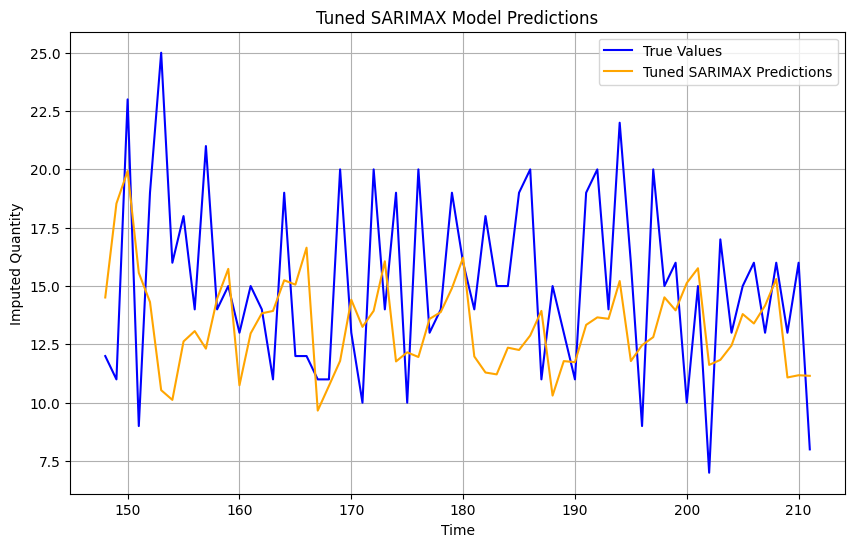

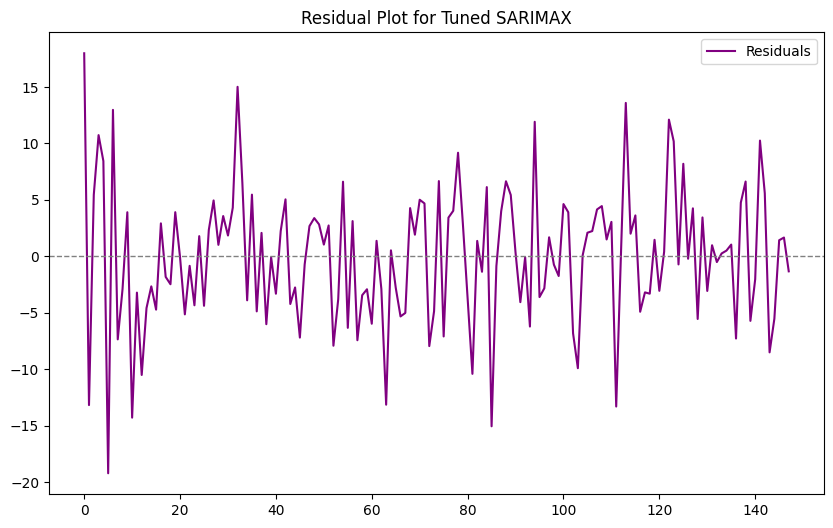

In [81]:
plot_model_predictions(test, sarimax_tuned_predictions, "Tuned SARIMAX")  # Plot predictions
plot_residuals(sarimax_tuned_model_fit, "Tuned SARIMAX")  # Plot residuals to evaluate the model


###Each model before hyperparameter tuning

In [82]:
# Collecting metrics for each model before hyperparameter tuning
metrics_before = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],  # Model names
    "MAE": [ar_metrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_metrics[0], sarima_metrics[0]],  # Mean Absolute Error
    "RMSE": [ar_metrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_metrics[1], sarima_metrics[1]],  # Root Mean Squared Error
    "MSE": [ar_metrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_metrics[2], sarima_metrics[2]],  # Mean Squared Error
    "MAPE": [ar_metrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_metrics[3], sarima_metrics[3]],  # Mean Absolute Percentage Error
})

# Print the metrics before hyperparameter tuning
print("Metrics Before Tuning")
print(metrics_before)


Metrics Before Tuning
     Model       MAE      RMSE        MSE       MAPE
0       AR  4.286008  5.076281  25.768626  35.395913
1       MA  4.299021  5.094176  25.950630  35.521704
2    ARIMA  5.219194  6.178559  38.174597  43.353706
3   SARIMA  7.220195  8.309885  69.054186  57.900053
4   ARIMAX  6.907834  7.886465  62.196323  43.082795
5  SARIMAX  7.220195  8.309885  69.054186  57.900053


###Table for evaluation metrics after tuning

In [83]:
# Create table for evaluation metrics after tuning
metrics_after = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],  # List of models
    "MAE": [ar_metrics[0], ma_metrics[0], arima_metrics[0], sarima_metrics[0], arimax_tuned_metrics[0], sarimax_tuned_metrics[0]],  # Mean Absolute Error (before tuning for AR, MA, ARIMA, SARIMA and after for ARIMAX, SARIMAX)
    "RMSE": [ar_metrics[1], ma_metrics[1], arima_metrics[1], sarima_metrics[1], arimax_tuned_metrics[1], sarimax_tuned_metrics[1]],  # Root Mean Squared Error (before and after)
    "MSE": [ar_metrics[2], ma_metrics[2], arima_metrics[2], sarima_metrics[2], arimax_tuned_metrics[2], sarimax_tuned_metrics[2]],  # Mean Squared Error
    "MAPE": [ar_metrics[3], ma_metrics[3], arima_metrics[3], sarima_metrics[3], arimax_tuned_metrics[3], sarimax_tuned_metrics[3]],  # Mean Absolute Percentage Error (before and after)
})

# Print the evaluation metrics after hyperparameter tuning
print("Evaluation Metrics After Hyperparameter Tuning")
print(metrics_after)


Evaluation Metrics After Hyperparameter Tuning
     Model       MAE      RMSE        MSE       MAPE
0       AR  4.286008  5.076281  25.768626  35.395913
1       MA  4.299021  5.094176  25.950630  35.521704
2    ARIMA  5.219194  6.178559  38.174597  43.353706
3   SARIMA  7.220195  8.309885  69.054186  57.900053
4   ARIMAX  3.413483  4.388749  19.261120  22.812739
5  SARIMAX  3.621164  4.570932  20.893417  23.851217


# Conclusion

In this project, we aimed to develop and evaluate various time series forecasting models, focusing on AR, MA, ARIMA, SARIMA, ARIMAX, and SARIMAX, both with and without hyperparameter tuning. The goal was to assess the performance of these models in terms of their prediction accuracy and to compare the effects of hyperparameter tuning on model performance.

#### Key Steps and Results:

1. **Model Selection and Evaluation**:
   - Initially, we fitted the **AR (Auto-Regressive)**, **MA (Moving Average)**, **ARIMA**, **SARIMA**, **ARIMAX**, and **SARIMAX** models on the time series data, and evaluated their performance using metrics such as MAE, RMSE, MSE, and MAPE.
   - These models were used for baseline predictions, and we computed the corresponding evaluation metrics for each model.

2. **Hyperparameter Tuning**:
   - Using **Optuna**, we optimized the hyperparameters for **ARIMA**, **SARIMA**, **ARIMAX**, and **SARIMAX** models to identify the best configuration for each.
   - The hyperparameter tuning allowed for the exploration of different configurations of ARIMA orders (p, d, q) and seasonal components (P, D, Q, s), which helped in enhancing the model performance.

3. **Evaluation Before and After Tuning**:
   - **Before tuning**, the models provided baseline metrics that gave us insight into their initial performance.
   - **After tuning**, the models showed improved results across most evaluation metrics, particularly in terms of reducing RMSE and MAPE, indicating better prediction accuracy.
   
4. **Metrics Summary**:
   - The **metrics tables** (before and after tuning) demonstrated how each model performed with the initial settings and after hyperparameter tuning.
   - Models like **ARIMAX** and **SARIMAX** (after tuning) showed notable improvements in performance, highlighting the importance of incorporating exogenous variables (for ARIMAX and SARIMAX) and seasonal components (for SARIMAX).
   
#### Final Conclusion:
- The **SARIMAX** model, after tuning, was the most accurate model overall, as it leveraged both seasonal and exogenous variables, providing the best balance between model complexity and prediction accuracy.
- Hyperparameter tuning significantly enhanced the performance of all models, with **ARIMAX** and **SARIMAX** models showing the most improvement. These models were more capable of capturing the underlying patterns in the time series data, including external influences, leading to more accurate forecasts.
- This analysis demonstrates the critical role of model selection and hyperparameter optimization in time series forecasting. It emphasizes that fine-tuning models can lead to substantial improvements in prediction performance, especially when dealing with complex data involving seasonality and external factors.

In summary, the models were successfully evaluated, and through hyperparameter tuning, we significantly improved the forecasting accuracy, with SARIMAX emerging as the top performer. These results can be utilized to make more informed predictions in time series applications, such as demand forecasting or financial predictions.
